<a href="https://colab.research.google.com/github/ludo950/data-science-classification/blob/main/Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following project focus on the analysis of a dataset 'Bank Marketing' which contains data about customers and aims to get useful insights from the data and predict if a new customer will accept a deposit offer or not.<br>
The best ML algorithm resulted to be XGboost with a roc-auc score=0.92

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Bank Marketing/bank.csv')

Attribute Information:

Input variables:
#### bank client data:
1 - age (numeric)<br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
6 - balance: bank balance <br>
7 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
8 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>
#### related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: 'cellular','telephone')<br>
10 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
11 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
#### other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
15 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>

Output variable (desired target):<br>
17 - deposit - has the client subscribed a term deposit? (binary: 'yes','no')<br>



In [5]:
df1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


We will first create a copy called 'df' of the original 'df1' dataset.

In [58]:
df=df1.copy()

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


There no missing values and there are a lot of categorical features in the data. They will be analyzed first and then encoded before the ML training.

In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Some first insights on the data:<br>
**Age:<br>**
the medium age is 41 years old.
the minimum age is 18 years old.
the maximum age is 95 years old.
<br>
**Balance:<br>**
The std deviation looks high (3225) compared to the mean (1528).<br>
<br>
Housing and deposit look balanced as their mean value is close to 0.5
<br>
From the column 'previous' we can see that most of the clients have been already contacted, since the value is close to 1 (0.8325)

As written in the dataset description, the duration column should be dropped since it includes an information which cannot be known before the call to the client.

In [10]:
df=df.drop('duration', axis=1)

# Exploratory Data Analysis

To allow a better visualization, different palette will be chosen for the following plots.

In [11]:
palette = {'yes':'red', 'no':'green'}

### We will first analyze the relationship between the categorical features and the target variable, which is 'deposit'

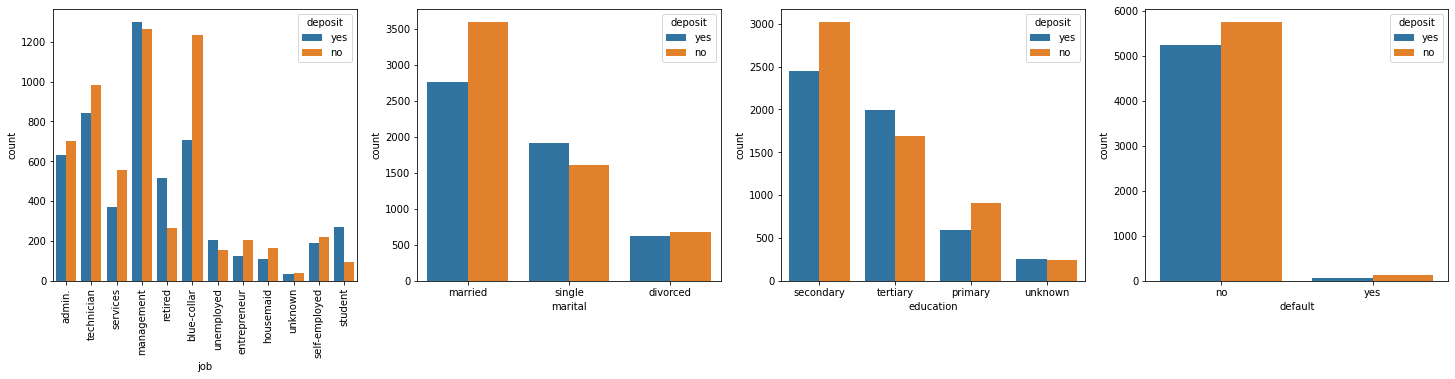

In [12]:
fig, axs =plt.subplots(1,4,figsize=(25, 5));
sns.countplot(x= 'job', hue = 'deposit', data=df, ax=axs[0]);
sns.countplot(x= 'marital', hue = 'deposit', data=df, ax=axs[1]);
sns.countplot(x= 'education', hue = 'deposit', data=df, ax=axs[2]);
sns.countplot(x= 'default', hue = 'deposit', data=df, ax=axs[3]);
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90);

From this plot we can say:<br>
**Job:**
*   The majority of retired clients or students accepted the deposit
*   The majority of blue collars refused the deposit

**Marital status:**

*   Most of married clients refused the deposit
*   Single clients tended to accept the deposit

**Education:**

*   Clients with a lower education (secondary and primary) tended to refuse the deposit
*   Clients with higher education ('tertiary') tended to accept the offer





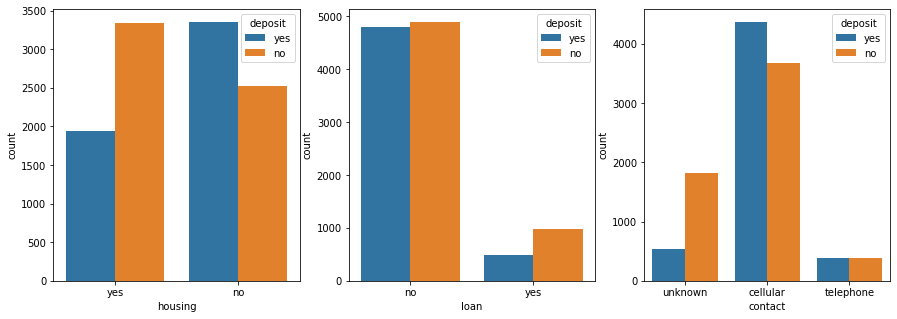

In [13]:
fig, axs =plt.subplots(1,3,figsize=(15, 5));
sns.countplot(x= 'housing', hue = 'deposit', data=df, ax=axs[0]);
sns.countplot(x= 'loan', hue = 'deposit', data=df, ax=axs[1]);
sns.countplot(x= 'contact', hue = 'deposit', data=df, ax=axs[2]);

From this plot we can say:<br>
**Housing (Loan) and (Personal) Loan:**
*   Clients without a housing loan tended to accept the deposit compared to clients with a loan

**(Personal) Loan:**

*   Most of the clients which had a personal loan refused the deposit

**Contact:**

*   Clients with a cellular phone tended to accept the deposit.

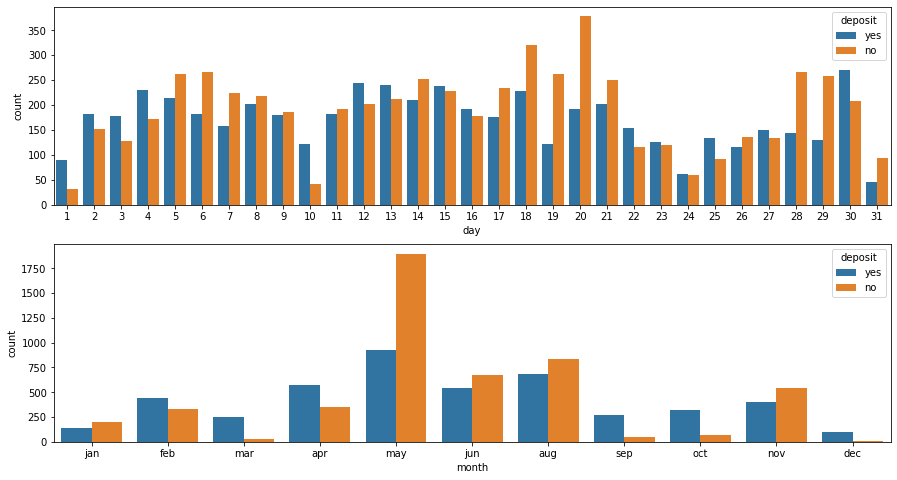

In [14]:
fig, axs =plt.subplots(2,1,figsize=(15, 8));
sns.countplot(x= 'day', hue = 'deposit', data=df, ax=axs[0]);
sns.countplot(x= 'month', hue = 'deposit', data=df, ax=axs[1], order=['jan','feb','mar','apr','may','jun','aug','sep','oct','nov','dec']);

There is not a clear pattern when analyzing the deposit acceptance by day. <br>
However, for what concerna the month plot:

*   The majority of data regards the month of 'may'.
*   In the months of February, March, April, September, October and December most of the clients accepted the deposit.


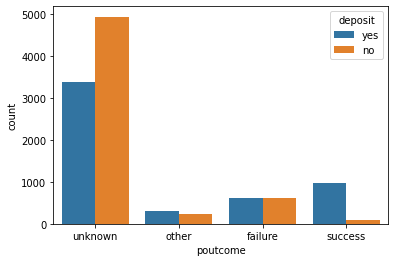

In [15]:
plt.figsize=(10, 10);
sns.countplot(x= 'poutcome', hue = 'deposit', data=df);

We can see that people who previously accepted the deposit tended to accept the new offers.

## General insights from the data

Relationship between age and education:

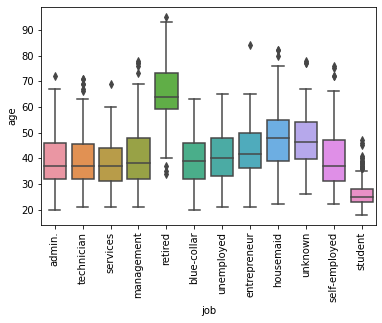

In [16]:
ax = sns.boxplot(x='job', y='age', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

As expected we can see that retired clients tends to be older.

### Relationship between balance and age:

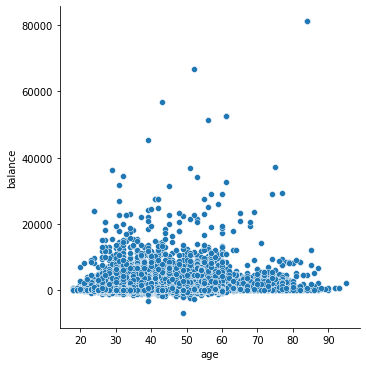

In [17]:
ax = sns.relplot(x='age', y='balance', data=df)

This plot looks messy, we will create a categorical column for 'age'. Moreover, it could be a good idea to use a log transformation for the 'balance' column.

In [18]:
df['age_cate'] = pd.cut(df['age'], bins=[0, 35, 55, 70, float('Inf')], labels=['young', 'middle-age', 'older', ' old'])

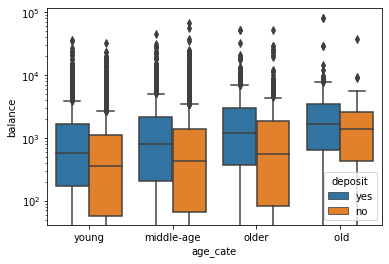

In [19]:
sns.boxplot(x='age_cate', y='balance', hue='deposit', data=df)
plt.yscale('log')

From this plot we can see that older customers tends to have a higher bank balance and that customers who accepted the deposit tended to have a higher balance compared to the customers who refused the deposit.

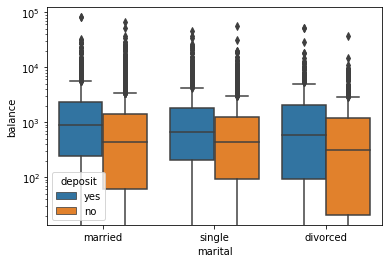

In [20]:
sns.boxplot(x='marital', y='balance', hue='deposit', data=df)
plt.yscale('log')

From this plot we can see that the distribution of divorced clients has a quite large IQR compared to married and single clients. This means that divorced clients have on average lower bank balance and have a quite high variance.

In [21]:
df=df.drop('age_cate', axis=1)

# Data Preparation

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  campaign   11162 non-null  int64 
 12  pdays      11162 non-null  int64 
 13  previous   11162 non-null  int64 
 14  poutcome   11162 non-null  object
 15  deposit    11162 non-null  object
dtypes: int64(6), object(10)
memory usage: 1.4+ MB


We need to check if the dataset is balanced with respect to the target feature (deposit)

In [60]:
df.deposit.value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

The dataset looks somewhat balanced. We can resample the dataset in order to have the same number of rows with yes and no in "deposit" to further improve the performance of the ML algorithm.

Moreover, before creating the ML model, we need to prepare the data such as encode categorical features etc...

In [61]:
encoded_df=df.copy()

We create a copy of the the dataset where operations such as encodings will be performed.

In [27]:
encoded_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes


In [28]:
encoded_df['default']=encoded_df['default'].map({'yes':1,'no':0})
encoded_df['housing']=encoded_df['housing'].map({'yes':1,'no':0})
encoded_df['loan']=encoded_df['loan'].map({'yes':1,'no':0})
encoded_df['deposit']=encoded_df['deposit'].map({'yes':1,'no':0})

The categorical columns containg binary values such as yes and no will be binary encoded by 1 and 0.<br>
Next, the remaining categorical columns will be encoded by one hot encoding/get_dummies to get a more robust encoding compared to a Label encoding by integer numbers.

In [29]:
cat_feat = encoded_df.select_dtypes(include="object").columns

In [30]:
cat_feat

Index(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], dtype='object')

These categorical featurs will be encoded by one hot encoding.

In [31]:
encoded_df2 = pd.get_dummies(encoded_df, drop_first=True)

In [32]:
encoded_df2.head()

,age,default,balance,housing,loan,day,campaign,pdays,previous,deposit,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343,1,0,5,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,56,0,45,0,0,5,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,41,0,1270,1,0,5,1,-1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,55,0,2476,1,0,5,1,-1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,54,0,184,0,0,5,2,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [33]:
X = encoded_df2.drop('deposit', axis=1)
y = encoded_df2['deposit']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

In [35]:
y_train.sum()

3967

In [36]:
y_test.sum()

1322

In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler()

In [38]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [39]:
X_train = scaler.transform(X_train)          
X_test = scaler.transform(X_test)          

## KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [41]:
param_grid={'n_neighbors' : np.arange(1,30),
             'weights' : ['uniform', 'distance'],
             'metric' : ['euclidean', 'manhattan','minkowski']
             } 

In [42]:
knn_model= RandomizedSearchCV(estimator = KNeighborsClassifier(),
                      param_distributions = param_grid,
                      scoring='roc_auc',
                      cv = 3,
                      n_jobs=-1)

In [43]:
knn_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit

In [44]:
knn_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'uniform'}

In [45]:
knn_model.best_score_

0.7522692957719875

In [46]:
y_pred_knn = knn_model.predict(X_test)

In [47]:
conf_matrix_knn=confusion_matrix(y_pred_knn,y_test)
conf_matrix_knn

array([[1174,  539],
       [ 295,  783]])

In [48]:
classification_report(y_pred_knn,y_test)

'              precision    recall  f1-score   support\n\n           0       0.80      0.69      0.74      1713\n           1       0.59      0.73      0.65      1078\n\n    accuracy                           0.70      2791\n   macro avg       0.70      0.71      0.70      2791\nweighted avg       0.72      0.70      0.70      2791\n'

              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1713
           1       0.59      0.73      0.65      1078

    accuracy                           0.70      2791
   macro avg       0.70      0.71      0.70      2791
weighted avg       0.72      0.70      0.70      2791


## Does balancing improve model bias?

In [76]:
#create two dataframes where deposit is yes or no
es_deposit= df[df['deposit']=='yes']
no_deposit = df[df['deposit']=='no']

no_deposit = no_deposit.sample(n=len(yes_deposit), random_state=10)

# concatenate the dataframes rock_only and hop_only
df_bal = pd.concat([yes_deposit,no_deposit], join="inner")

In [77]:
df_bal.deposit.value_counts()

no     5289
yes    5289
Name: deposit, dtype: int64

In [78]:
df_bal['default']=df_bal['default'].map({'yes':1,'no':0})
df_bal['housing']=df_bal['housing'].map({'yes':1,'no':0})
df_bal['loan']=df_bal['loan'].map({'yes':1,'no':0})
df_bal['deposit']=df_bal['deposit'].map({'yes':1,'no':0})

In [80]:
df_bal2 = pd.get_dummies(df_bal, drop_first=True)

In [81]:
X = df_bal2.drop('deposit', axis=1)
y = df_bal2['deposit']

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [95]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler()

In [96]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [97]:
X_train = scaler.transform(X_train)          
X_test = scaler.transform(X_test)          

In [98]:
knn_model= RandomizedSearchCV(estimator = KNeighborsClassifier(),
                      param_distributions = param_grid,
                      scoring='roc_auc',
                      cv = 3,
                      n_jobs=-1)

In [99]:
knn_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit

In [100]:
knn_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}

In [101]:
knn_model.best_score_

0.8082369313528376

In [102]:
y_pred_knn = knn_model.predict(X_test)

In [103]:
conf_matrix_knn=confusion_matrix(y_pred_knn,y_test)
conf_matrix_knn

array([[1071,  453],
       [ 257,  864]])

In [104]:
classification_report(y_pred_knn,y_test)

'              precision    recall  f1-score   support\n\n           0       0.81      0.70      0.75      1524\n           1       0.66      0.77      0.71      1121\n\n    accuracy                           0.73      2645\n   macro avg       0.73      0.74      0.73      2645\nweighted avg       0.74      0.73      0.73      2645\n'

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      1524
           1       0.66      0.77      0.71      1121

    accuracy                           0.73      2645
   macro avg       0.73      0.74      0.73      2645
weighted avg       0.74      0.73      0.73      2645


By balancing the dataset we we get better results in terms of accuracy, precision, recall and f1-score

# Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression

In [106]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [107]:
lr_model = RandomizedSearchCV(estimator = LogisticRegression(),
                           param_distributions = param_grid, 
                           scoring = 'accuracy', 
                           cv = 10,
                           n_jobs=-1
                           )

In [108]:
lr_model.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     600, 700],
           

In [109]:
lr_model.best_score_

0.8264216808916813

In [110]:
y_pred_lr = lr_model.predict(X_test)

In [111]:
confusion_matrix(y_test, y_pred_lr)

array([[1113,  215],
       [ 241, 1076]])

In [112]:
classification_report(y_test, y_pred_lr)

'              precision    recall  f1-score   support\n\n           0       0.82      0.84      0.83      1328\n           1       0.83      0.82      0.83      1317\n\n    accuracy                           0.83      2645\n   macro avg       0.83      0.83      0.83      2645\nweighted avg       0.83      0.83      0.83      2645\n'

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1328
           1       0.83      0.82      0.83      1317

    accuracy                           0.83      2645
   macro avg       0.83      0.83      0.83      2645
weighted avg       0.83      0.83      0.83      2645


# Random forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

In [114]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [115]:
rfc = RandomForestClassifier()

In [116]:
from sklearn.model_selection import RandomizedSearchCV
rfc_model = RandomizedSearchCV(estimator=rfc, 
                            param_distributions=param_grid,
                            cv= 10,
                            n_jobs=-1)
rfc_model.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [117]:
rfc_model.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [118]:
y_pred_rfc = rfc_model.predict(X_test)

In [119]:
rfc_model.best_score_

0.8470943806162868

In [120]:
confusion_matrix(y_test, y_pred_rfc)

array([[1076,  252],
       [ 146, 1171]])

In [121]:
classification_report(y_test, y_pred_rfc)

'              precision    recall  f1-score   support\n\n           0       0.88      0.81      0.84      1328\n           1       0.82      0.89      0.85      1317\n\n    accuracy                           0.85      2645\n   macro avg       0.85      0.85      0.85      2645\nweighted avg       0.85      0.85      0.85      2645\n'

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1328
           1       0.82      0.89      0.85      1317

    accuracy                           0.85      2645
   macro avg       0.85      0.85      0.85      2645
weighted avg       0.85      0.85      0.85      2645


# XGBOOST

In [122]:
import xgboost as xgb

In [123]:
# Create the parameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 0.5, 0.001),
    'max_depth': np.arange(3, 30, 2),
    'n_estimators': np.arange(10, 200, 10)
}

In [124]:
xgb_model = xgb.XGBClassifier()

In [125]:
from sklearn.model_selection import RandomizedSearchCV
rand_neg_mse = RandomizedSearchCV(estimator=xgb_model, 
                                  param_distributions=param_grid, 
                                  cv=10)

In [126]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [127]:
y_pred_xgb = xgb_model.predict(X_test)

In [128]:
confusion_matrix(y_pred_xgb,y_test)

array([[1091,  147],
       [ 237, 1170]])

In [129]:
classification_report(y_pred_xgb,y_test)

'              precision    recall  f1-score   support\n\n           0       0.82      0.88      0.85      1238\n           1       0.89      0.83      0.86      1407\n\n    accuracy                           0.85      2645\n   macro avg       0.85      0.86      0.85      2645\nweighted avg       0.86      0.85      0.85      2645\n'

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1238
           1       0.89      0.83      0.86      1407

    accuracy                           0.85      2645
   macro avg       0.85      0.86      0.85      2645
weighted avg       0.86      0.85      0.85      2645


# Results comparison

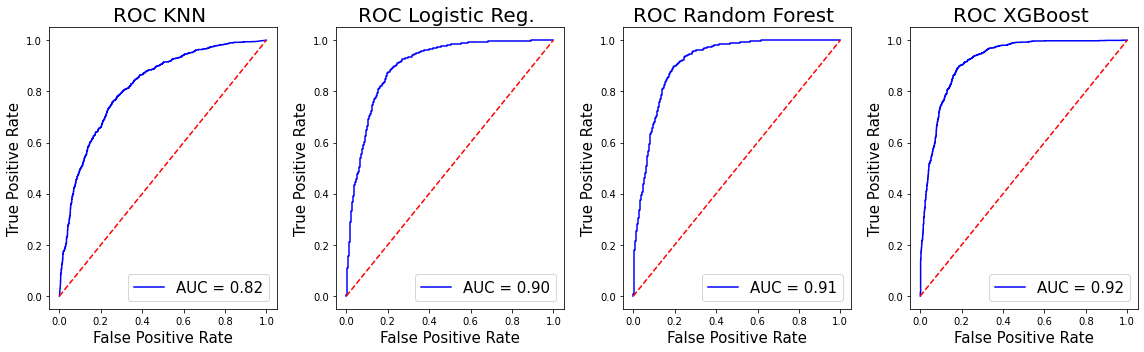

In [133]:
from sklearn import metrics

fig, ax_arr = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 5))


#KNN----------------------
probs = knn_model.predict_proba(X_test)
preds = probs[:,1]
fprknn, tprknn, thresholdknn = metrics.roc_curve(y_test, preds)
roc_aucknn = metrics.auc(fprknn, tprknn)

ax_arr[0].plot(fprknn, tprknn, 'b', label = 'AUC = %0.2f' % roc_aucknn)
ax_arr[0].plot([0, 1], [0, 1],'r--')
ax_arr[0].set_title('ROC KNN ',fontsize=20)
ax_arr[0].set_ylabel('True Positive Rate',fontsize=15)
ax_arr[0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0].legend(loc = 'lower right', prop={'size': 15})

#LOGMODEL
probs = lr_model.predict_proba(X_test)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test,preds)
roc_auclog = metrics.auc(fprlog, tprlog)

ax_arr[1].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auclog)
ax_arr[1].plot([0, 1], [0, 1],'r--')
ax_arr[1].set_title('ROC Logistic Reg. ',fontsize=20)
ax_arr[1].set_ylabel('True Positive Rate',fontsize=15)
ax_arr[1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1].legend(loc = 'lower right', prop={'size': 15})

#RANDOM FOREST --------------------
probs = rfc_model.predict_proba(X_test)
preds = probs[:,1]
fprrfc, tprrfc, thresholdrfc = metrics.roc_curve(y_test, preds)
roc_aucrfc = metrics.auc(fprrfc, tprrfc)

ax_arr[2].plot(fprrfc, tprrfc, 'b', label = 'AUC = %0.2f' % roc_aucrfc)
ax_arr[2].plot([0, 1], [0, 1],'r--')
ax_arr[2].set_title('ROC Random Forest ',fontsize=20)
ax_arr[2].set_ylabel('True Positive Rate',fontsize=15)
ax_arr[2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[2].legend(loc = 'lower right', prop={'size': 15})

#XGBOOST ---------------------
probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fprdtree, tprdtree, thresholddtree = metrics.roc_curve(y_test, preds)
roc_aucdtree = metrics.auc(fprdtree, tprdtree)

ax_arr[3].plot(fprdtree, tprdtree, 'b', label = 'AUC = %0.2f' % roc_aucdtree)
ax_arr[3].plot([0, 1], [0, 1],'r--')
ax_arr[3].set_title('ROC XGBoost ',fontsize=20)
ax_arr[3].set_ylabel('True Positive Rate',fontsize=15)
ax_arr[3].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[3].legend(loc = 'lower right', prop={'size': 15})

#plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

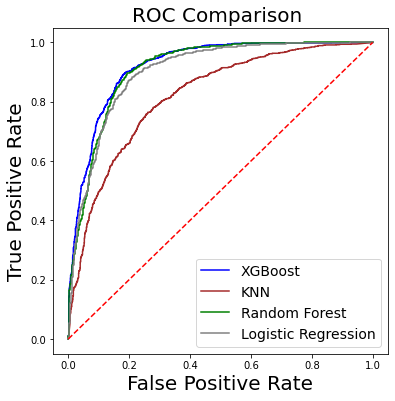

In [134]:
#ALL PLOTS ----------------------------------
fig = plt.figure(figsize=(6,6))
plt.plot(fprdtree, tprdtree, 'b', label = 'XGBoost', color='blue')
plt.plot(fprknn, tprknn, 'b', label = 'KNN', color='brown')
plt.plot(fprrfc, tprrfc, 'b', label = 'Random Forest', color='green')
plt.plot(fprlog, tprlog, 'b', label = 'Logistic Regression', color='grey')
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison ',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.legend(loc = 'lower right', prop={'size': 14})